# Imports and Helper Functions:

In [29]:
# Import packages
# DL Packages
import tensorflow as tf
import keras

# Others
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import sympy as sym
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [43]:

def plot_confusion_matrix(Y: np.array, pred: np.array, labels=[], savename="", logscale=False, title="Confustion Matrix"):
    """
    Convenience function for generating a confusion Matrix

    Args:
        Y (np.array): Actual labels for the dataset (n rows, 1 column)
        pred (np.array): Predicted labels for the data (n rows, 1 column)
        labels (list of str): class labels
        savename (str, optional): File to save plot to. If none is given shows figure.
                                    Defaults to "".

    Returns:
        confusion matrix
    """
    # Figure out predicted class -- infer from Y and pred the number of classes
    if Y.shape[1] > 1:
        Y_labels = np.zeros(Y.shape[0], dtype=int)
        pred_labels = np.zeros_like(Y_labels)
        for i in range(Y.shape[0]):
            Y_labels[i] = np.argmax(Y[i])
            pred_labels[i] = np.argmax(pred[i])
    else:
        Y_labels = Y
        pred_labels = (Y >= 0.5).astype(int)
    cm = confusion_matrix(Y_labels, pred_labels)
    f, ax = plt.subplots()
    if logscale:
        from matplotlib.colors import LogNorm, Normalize
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', norm=LogNorm())
    else:
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
    # labels, title and ticks
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title(title)
    if not labels:
        labels = np.arange(max(Y.shape[1], 2))
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    if savename != "":
        plt.savefig(savename)
        plt.close(f)
    else:
        f.set_size_inches((8,8))
        plt.tight_layout()
        plt.show()
        
    return cm

# Examine and Preprocess the Data:

In [31]:
data = pd.read_csv("Final_News_DF_Labeled_ExamDataset.csv")
data

,LABEL,according,agency,ahead,alabama,amazon,america,american,announced,appeared,...,wolverines,women,work,working,world,wrote,year,years,york,young
0,politics,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,politics,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,politics,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,politics,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,politics,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,science,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1489,science,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1490,science,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1491,science,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each entry is labeled by a catergory of article, with the columns representing words that appeared or not

In [32]:
data.groupby("LABEL").size()

LABEL
football    500
politics    497
science     496
dtype: int64

Turn it into data matrix X and label vector Y. X is already OHE, while Y needs to be turned into OHE.

In [33]:
X = data[[c for c in data.columns if c != "LABEL"]].to_numpy()
Y_raw = data["LABEL"].to_numpy()

# Do the OHE
vals = np.unique(Y_raw)
val_map = {}
for i, v in enumerate(vals):
    val_map[v] = i
Y = np.zeros((Y_raw.shape[0], len(val_map)), dtype=int)
for i in range(Y.shape[0]):
    Y[i, val_map[Y_raw[i]]] = 1

print("val_map", val_map)
print("X shape:", X.shape)
print("X:\n", X)
print("Y shape:", Y.shape)
print("Y:\n", Y)

val_map {'football': 0, 'politics': 1, 'science': 2}
X shape: (1493, 300)
X:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Y shape: (1493, 3)
Y:
 [[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


Preprocessing looks good. The data is balanced, with an approximately equal number of entries from each class. As it did not come with a specified train/test split, I'll do my own n-fold cross validation. As there are approximately 500 in each class, I'll do 5 fold to get about 100 of each in each test set.

In [34]:
splits = KFold(n_splits=5, shuffle=True, random_state=7)

Let's look at the balance of the splits to make sure it worked:

In [35]:
fold = 1
for train, test in splits.split(X, Y_raw):
    print("---------------------------")
    print("FOLD:", fold)
    print("TRAIN:", np.unique(Y_raw[train], return_counts=True))
    print("TEST:", np.unique(Y_raw[test], return_counts=True))
    fold += 1

---------------------------
FOLD: 1
TRAIN: (array(['football', 'politics', 'science'], dtype=object), array([400, 391, 403]))
TEST: (array(['football', 'politics', 'science'], dtype=object), array([100, 106,  93]))
---------------------------
FOLD: 2
TRAIN: (array(['football', 'politics', 'science'], dtype=object), array([402, 396, 396]))
TEST: (array(['football', 'politics', 'science'], dtype=object), array([ 98, 101, 100]))
---------------------------
FOLD: 3
TRAIN: (array(['football', 'politics', 'science'], dtype=object), array([402, 402, 390]))
TEST: (array(['football', 'politics', 'science'], dtype=object), array([ 98,  95, 106]))
---------------------------
FOLD: 4
TRAIN: (array(['football', 'politics', 'science'], dtype=object), array([393, 404, 398]))
TEST: (array(['football', 'politics', 'science'], dtype=object), array([107,  93,  98]))
---------------------------
FOLD: 5
TRAIN: (array(['football', 'politics', 'science'], dtype=object), array([403, 395, 397]))
TEST: (array([

Folds are looking balanced, let's move ahead with making some models after defining some helpers for the folding:

In [93]:
def train_on_folds(model_fn, splits, X, Y, epochs=100, batch_size=2000):

    models = []
    histories = []

    # Train a different model for each fold
    for fold_n, (train, test) in enumerate(splits.split(X, Y)):

        print("-----------------")
        print("Training on fold", fold_n)

        X_train = X[train]
        Y_train = Y[train]

        X_test = X[test]
        Y_test = Y[test]
        
        model = model_fn()
        history = model.fit(X_train, Y_train, epochs=epochs, validation_data = (X_test, Y_test))

        models.append(model)
        histories.append(history)

    return models, histories

def pred_on_folds(models, splits, X, Y):

    Y_pred = np.zeros_like(Y, dtype=float)
    for fold_n, (train, test) in enumerate(splits.split(X, Y)):
        preds = models[fold_n].predict(X[test])
        Y_pred[test] = preds
    
    return Y_pred

# ANN Model:

For the ANN model I will start with an embedding layer, then three dense layers and an output layer. My intent is to keep the embedding layer the same between the different models:

In [106]:
def ann_model(embedding_size=32, input_size=X.shape[1], output_size=Y.shape[1], optimizer="adam", loss="categorical_crossentropy",
              metrics=[keras.metrics.CategoricalAccuracy()]):

    model = keras.models.Sequential([
                keras.layers.Input(input_size),
                keras.layers.Dense(embedding_size),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(embedding_size, activation="relu"),
                keras.layers.Dense(embedding_size/4, activation="relu"),
                keras.layers.Dense(output_size, activation="softmax")
            ])
    
    model.build(input_size)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

ann_test = ann_model()
ann_test.summary()


Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_272 (Dense)           (None, 32)                9632      
                                                                 
 dropout_40 (Dropout)        (None, 32)                0         
                                                                 
 dense_273 (Dense)           (None, 32)                1056      
                                                                 
 dense_274 (Dense)           (None, 8)                 264       
                                                                 
 dense_275 (Dense)           (None, 3)                 27        
                                                                 
Total params: 10979 (42.89 KB)
Trainable params: 10979 (42.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
models_ann, histories_ann = train_on_folds(ann_model, splits, X, Y, epochs=10)
pred_ann = pred_on_folds(models_ann, splits, X, Y)


-----------------
Training on fold 0
Epoch 1/10
38/38 [==============================] - 1s 4ms/step - loss: 1.0471 - categorical_accuracy: 0.4238 - val_loss: 0.9760 - val_categorical_accuracy: 0.5518
Epoch 2/10
38/38 [==============================] - 0s 2ms/step - loss: 0.9436 - categorical_accuracy: 0.5980 - val_loss: 0.8704 - val_categorical_accuracy: 0.6421
Epoch 3/10
38/38 [==============================] - 0s 2ms/step - loss: 0.8154 - categorical_accuracy: 0.6784 - val_loss: 0.7334 - val_categorical_accuracy: 0.7090
Epoch 4/10
38/38 [==============================] - 0s 2ms/step - loss: 0.6646 - categorical_accuracy: 0.7613 - val_loss: 0.6172 - val_categorical_accuracy: 0.7258
Epoch 5/10
38/38 [==============================] - 0s 2ms/step - loss: 0.5481 - categorical_accuracy: 0.7781 - val_loss: 0.5627 - val_categorical_accuracy: 0.7559
Epoch 6/10
38/38 [==============================] - 0s 2ms/step - loss: 0.4762 - categorical_accuracy: 0.8141 - val_loss: 0.5540 - val_categori

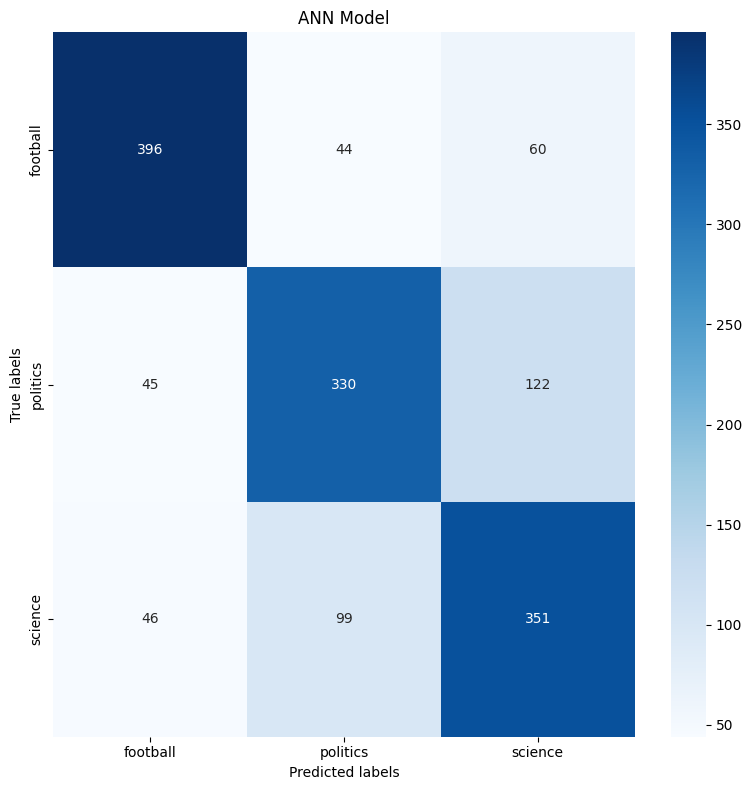

array([[396,  44,  60],
       [ 45, 330, 122],
       [ 46,  99, 351]])

In [108]:
plot_confusion_matrix(Y, pred_ann, labels=list(vals), logscale=False, title="ANN Model")

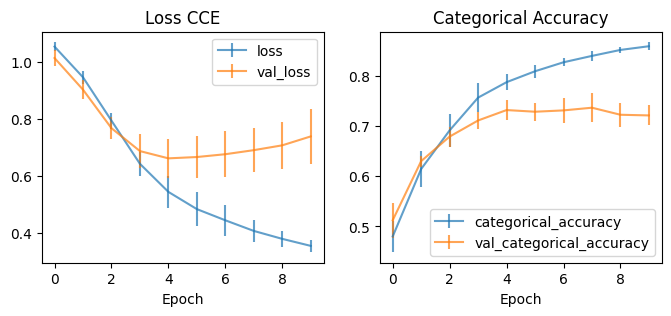

In [109]:
def get_mean_std(histories, key):
    vals = np.array([h.history[key] for h in histories])
    return np.mean(vals, axis=0), np.std(vals, axis=0)

def plot_key(ax, x_vals, histories, key):
    mean, std = get_mean_std(histories, key)
    ax.errorbar(x_vals, mean, std, label=key, errorevery=1, alpha=0.7)


f, ax = plt.subplots(ncols=2)
f.set_size_inches(8,3)
epochs = np.arange(len(histories_ann[0].history["loss"]))
plot_key(ax[0], epochs, histories_ann, "loss")
plot_key(ax[0], epochs, histories_ann, "val_loss")
plot_key(ax[1], epochs, histories_ann, "categorical_accuracy")
plot_key(ax[1], epochs, histories_ann, "val_categorical_accuracy")
ax[0].set_title("Loss CCE")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_title("Categorical Accuracy")
ax[1].legend();

# CNN Model:

In [113]:
def cnn_model(embedding_size=32, input_size=X.shape[1], output_size=Y.shape[1], optimizer="adam", loss="categorical_crossentropy",
              metrics=[keras.metrics.CategoricalAccuracy()]):

    model = keras.models.Sequential([
                # This initial dense layer serves as an embedding layer
                keras.layers.Input(input_size),
                keras.layers.Dense(embedding_size),
                keras.layers.Dropout(0.1),
                keras.layers.Reshape((-1, embedding_size, 1))
                
                # Now begin the convolutional part
                keras.layers.Conv1D(filters=embedding_size, kernel_size=3, strides=1, padding="same", activation="relu"),
                keras.layers.MaxPool1D(pool_size=2),
                keras.layers.Conv1D(filters=embedding_size/4, kernel_size=3, strides=1, padding="same", activation="relu"),
                keras.layers.MaxPool1D(pool_size=2),
                keras.layers.Flatten(),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(output_size, activation="softmax")
            ])
    
    model.build(input_size)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

cnn_test = cnn_model()
cnn_test.summary()

ValueError: Input 0 of layer "conv1d_1" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 32)